In [ ]:
import pandas as pd
import numpy as np
import sys
import yaml
import numpy as np
import logging
import keras
import tensorflow as tf
from utils.constants import RESULT_DIR, SRC_DIR, SEED
from utils.data_handler import get_tsc_train_dataset, preprocess_data
from models.clf_wrapper import ClassifierWrapper
from models.trigger_gen import TriggerGenerator
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Force Times New Roman
plt.style.use('seaborn-v0_8-whitegrid')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'        # main font
mpl.rcParams['font.size'] = 14                         # optional default size
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 11
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'       # keeps math consistent
mpl.rcParams['axes.unicode_minus'] = False             # proper minus sign

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [35]:
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import matplotlib as mpl

def draw_backdoor_analysis(training_asr, zero_inject_asr, one_inject_asr, one_epoch_gen_asr, four_epoch_gen_asr, six_epoch_gen_asr, legend_axis):
    # Force Times New Roman
    plt.figure(figsize=(18, 9))
    plt.style.use('seaborn-v0_8-whitegrid')
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['font.size'] = 18
    mpl.rcParams['axes.titlesize'] = 20
    mpl.rcParams['axes.labelsize'] = 20
    mpl.rcParams['legend.fontsize'] = 15
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
    mpl.rcParams['axes.unicode_minus'] = False  

    ax = plt.gca()

    colors = ['#808080', '#2E86C1', '#E74C3C', '#8E44AD', '#27AE60', '#E67E22']
    markers = ['^', 'o', 's', 'D', 'v', '*']

    # Final ASR values
    final_training_asr = round(training_asr[-1]*100, 2)
    final_zero_inject_asr = round(zero_inject_asr[-1]*100, 2)
    final_one_inject_asr = round(one_inject_asr[-1]*100, 2)
    final_one_epoch_gen_asr = round(one_epoch_gen_asr[-1]*100, 2)
    final_four_epoch_gen_asr = round(four_epoch_gen_asr[-1]*100, 2)
    final_six_epoch_gen_asr = round(six_epoch_gen_asr[-1]*100, 2)

    series = [
        (f"Backdoor Injection Phase - {final_training_asr}%", training_asr, colors[0], markers[0]),
        (f"No Data injection - {final_zero_inject_asr}%", zero_inject_asr, colors[1], markers[1]),
        (f"Only Data injection - {final_one_inject_asr}%", one_inject_asr, colors[2], markers[2]),
        (f"Data injection & Update every 2 epochs - {final_one_epoch_gen_asr}%", one_epoch_gen_asr, colors[3], markers[3]),
        (f"Data injection & Update every 4 epochs - {final_four_epoch_gen_asr}%", four_epoch_gen_asr, colors[4], markers[4]),
        (f"Data injection & Update every 6 epochs - {final_six_epoch_gen_asr}%", six_epoch_gen_asr, colors[5], markers[5]),
    ]

    train_len = len(training_asr)
    max_len = max(len(s) for _, s, _, _ in series[:])

    line_objs = []
    for idx, (label, data, color, marker) in enumerate(series):
        if idx == 0:
            x = range(len(data))
        else:
            x = range(train_len, train_len + len(data))
        data_to_plot = data
        ln, = ax.plot(
            x, data,
            label=label,
            marker=marker,
            linewidth=3,
            markersize=7,
            color=color,
            markerfacecolor='white',
            markeredgewidth=2,
            alpha=0.9
        )
        line_objs.append(ln)

    # Shading
    ax.axvspan(0, train_len, color=colors[0], alpha=0.08)
    ax.axvspan(train_len, train_len + max_len, color=colors[4], alpha=0.08)

    # Phase & baseline lines
    ax.axvline(train_len, color='gray', linestyle='--', linewidth=2, alpha=0.7)
    ax.axhline(training_asr[0], color='black', linestyle=':', linewidth=1.4, alpha=0.6)

    # Labels
    ax.set_xlabel('Epoch', fontsize=23, fontweight='bold', labelpad=14)
    ax.set_ylabel('Target ASR', fontsize=23, fontweight='bold', labelpad=14)

    # Y scaling
    all_data = [d for _, d, _, _ in series]
    y_min = min(min(d) for d in all_data)
    y_max = max(max(d) for d in all_data)
    if y_max <= 1:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        ax.set_yticks(np.arange(0, 1.05, 0.1))
        ax.set_ylim(max(0, y_min - 0.05), min(1, y_max + 0.05))
    ax.set_xticks(range(0, train_len + max_len + 1, 5))
    ax.set_xlim(-1, train_len + max_len + 1)

    leg1 = ax.legend(
        handles=line_objs,
        labels=[ln.get_label() for ln in line_objs],
        title='Strategies',
        loc='center right',
        bbox_to_anchor=legend_axis,
        frameon=True,
        fancybox=True,
        shadow=False,
        borderpad=0.7,
        fontsize=21
    )
    leg1.get_frame().set_alpha(0.9)
    leg1.set_title("Final ASR", prop={'size':20, 'weight':'bold', 'family':'Times New Roman'})

    # Style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.grid(True, alpha=0.35, linewidth=0.8)

    plt.tight_layout()
    plt.show()

# MotionSense Dataset

Training Results Path: /home/fmg2/v-thanh/Code/results/TSBA/MotionSense/with_bd/bb_resnet_exp_0-t_2-clf_transformer/attack_metrics_resnet_to_transformer.csv
Zero Injection Results: /home/fmg2/v-thanh/Code/results/TSBA/MotionSense/continuous_bd/zero_injection/continuous_attack_metrics_transformer.csv
One Injection Results: /home/fmg2/v-thanh/Code/results/TSBA/MotionSense/continuous_bd/one_injection/continuous_attack_metrics_transformer.csv
One Epoch Gen Results: /home/fmg2/v-thanh/Code/results/TSBA/MotionSense/continuous_bd/cb_exp1_t2_surro_resnet_target_transformer/continuous_attack_metrics_transformer.csv
Two Epoch Gen Results: /home/fmg2/v-thanh/Code/results/TSBA/MotionSense/continuous_bd/cb_exp2_t2_surro_resnet_target_transformer/continuous_attack_metrics_transformer.csv
Four Epoch Gen Results: /home/fmg2/v-thanh/Code/results/TSBA/MotionSense/continuous_bd/cb_exp3_t2_surro_resnet_target_transformer/continuous_attack_metrics_transformer.csv


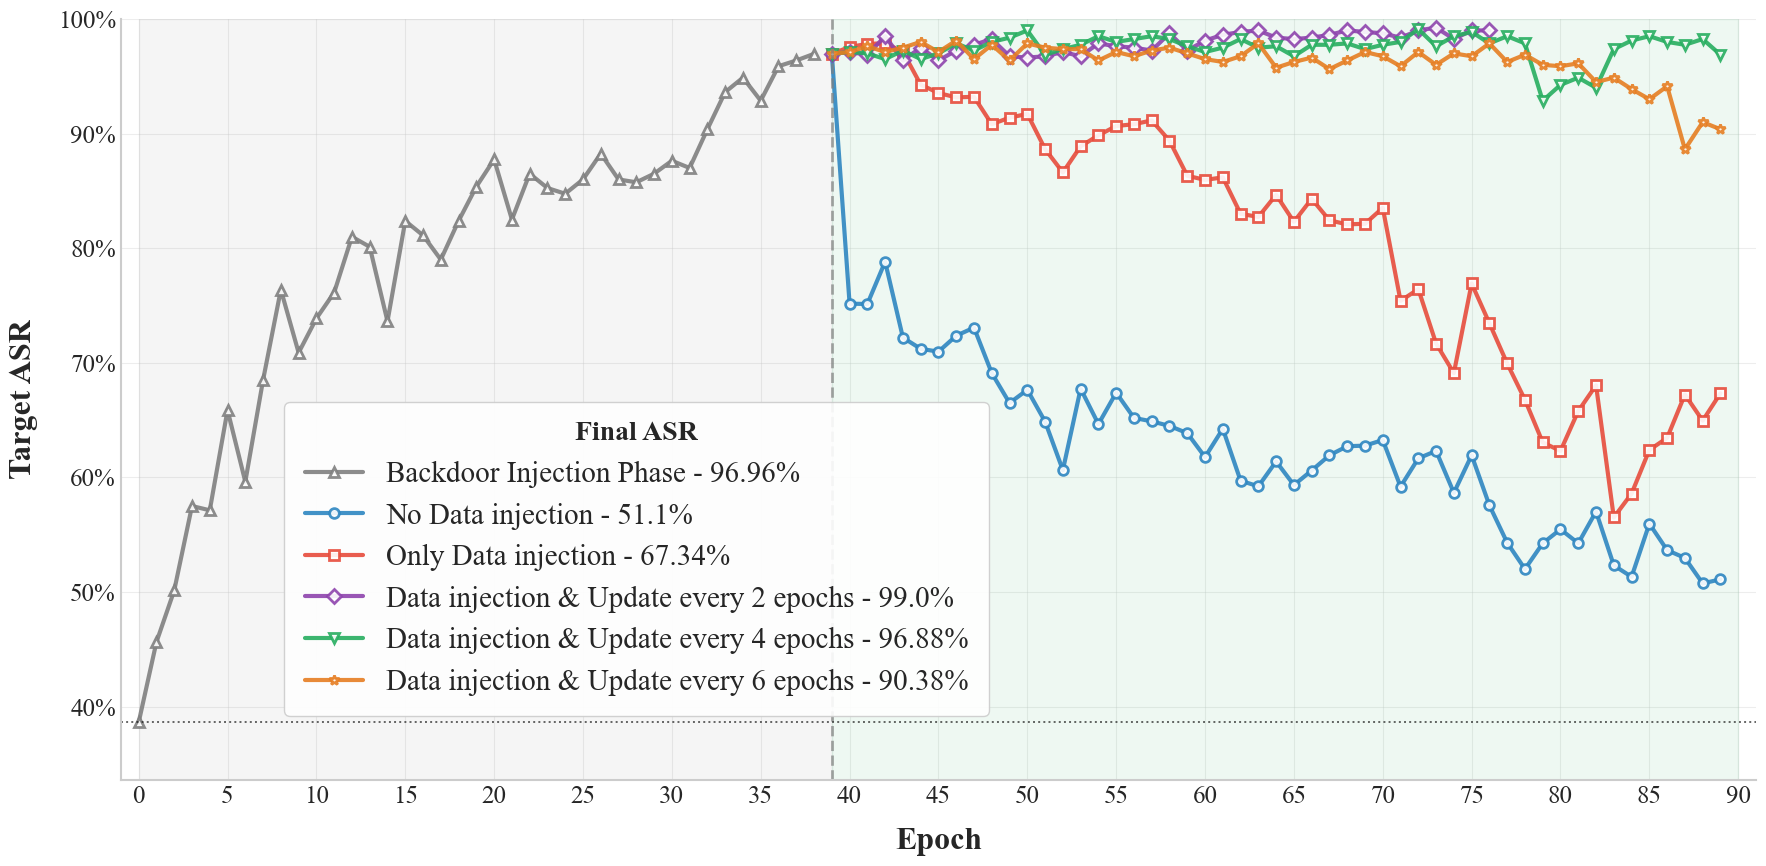

In [36]:
training_results = f"{SOURCE_DIR}/results/TSBA/MotionSense/with_bd/bb_resnet_exp_0-t_2-clf_transformer/attack_metrics_resnet_to_transformer.csv"
zero_injection_results = f"{SOURCE_DIR}/results/TSBA/MotionSense/continuous_bd/zero_injection/continuous_attack_metrics_transformer.csv"
only_injection_results = f"{SOURCE_DIR}/results/TSBA/MotionSense/continuous_bd/one_injection/continuous_attack_metrics_transformer.csv"
two_epoch_gen_results = f"{SOURCE_DIR}/results/TSBA/MotionSense/continuous_bd/cb_exp1_t2_surro_resnet_target_transformer/continuous_attack_metrics_transformer.csv"
four_epoch_gen_results = f"{SOURCE_DIR}/results/TSBA/MotionSense/continuous_bd/cb_exp2_t2_surro_resnet_target_transformer/continuous_attack_metrics_transformer.csv"
six_epoch_gen_results = f"{SOURCE_DIR}/results/TSBA/MotionSense/continuous_bd/cb_exp3_t2_surro_resnet_target_transformer/continuous_attack_metrics_transformer.csv"
print("Training Results Path:", training_results)
print("Zero Injection Results:", zero_injection_results)
print("One Injection Results:", only_injection_results)
print("One Epoch Gen Results:", two_epoch_gen_results)
print("Two Epoch Gen Results:", four_epoch_gen_results)
print("Four Epoch Gen Results:", six_epoch_gen_results)

training_result_df = pd.read_csv(training_results)
training_result_df = training_result_df[training_result_df["Attack Epoch"] == 2]
zero_inject_pd = pd.read_csv(zero_injection_results)
one_inject_pd = pd.read_csv(only_injection_results)
one_epoch_gen_pd = pd.read_csv(two_epoch_gen_results)
four_epoch_gen_pd = pd.read_csv(four_epoch_gen_results)
six_epoch_gen_pd = pd.read_csv(six_epoch_gen_results)

# Data (already prepared earlier)
training_asr = training_result_df['Target ASR'].values
zero_inject_asr = zero_inject_pd['Target ASR'].values
one_inject_asr = one_inject_pd['Target ASR'].values
one_epoch_gen_asr = one_epoch_gen_pd['Target ASR'].values
four_epoch_gen_asr = four_epoch_gen_pd['Target ASR'].values
six_epoch_gen_asr = six_epoch_gen_pd['Target ASR'].values
training_asr[-1] = zero_inject_asr[0]

draw_backdoor_analysis(training_asr, 
                       zero_inject_asr, 
                       one_inject_asr, 
                       one_epoch_gen_asr, 
                       four_epoch_gen_asr, 
                       six_epoch_gen_asr,
                       legend_axis=(0.54, 0.29))

# iAWE Dataset

Training Results Path: /home/fmg2/v-thanh/Code/results/TSBA/iAWE/with_bd/bb_resnet_exp_3-t_2-clf_fcn/attack_metrics_resnet_to_fcn.csv
Zero Injection Results: /home/fmg2/v-thanh/Code/results/TSBA/iAWE/continuous_bd/cb_exp4_t2_surro_resnet_target_fcn/continuous_attack_metrics_fcn.csv
Only Injection Results: /home/fmg2/v-thanh/Code/results/TSBA/iAWE/continuous_bd/cb_exp5_t2_surro_resnet_target_fcn/continuous_attack_metrics_fcn.csv
Two Epoch Gen Results: /home/fmg2/v-thanh/Code/results/TSBA/iAWE/continuous_bd/cb_exp1_t2_surro_resnet_target_fcn/continuous_attack_metrics_fcn.csv
Four Epoch Gen Results: /home/fmg2/v-thanh/Code/results/TSBA/iAWE/continuous_bd/cb_exp2_t2_surro_resnet_target_fcn/continuous_attack_metrics_fcn.csv
Six Epoch Gen Results: /home/fmg2/v-thanh/Code/results/TSBA/iAWE/continuous_bd/cb_exp3_t2_surro_resnet_target_fcn/continuous_attack_metrics_fcn.csv
6 51 51 51 51 51


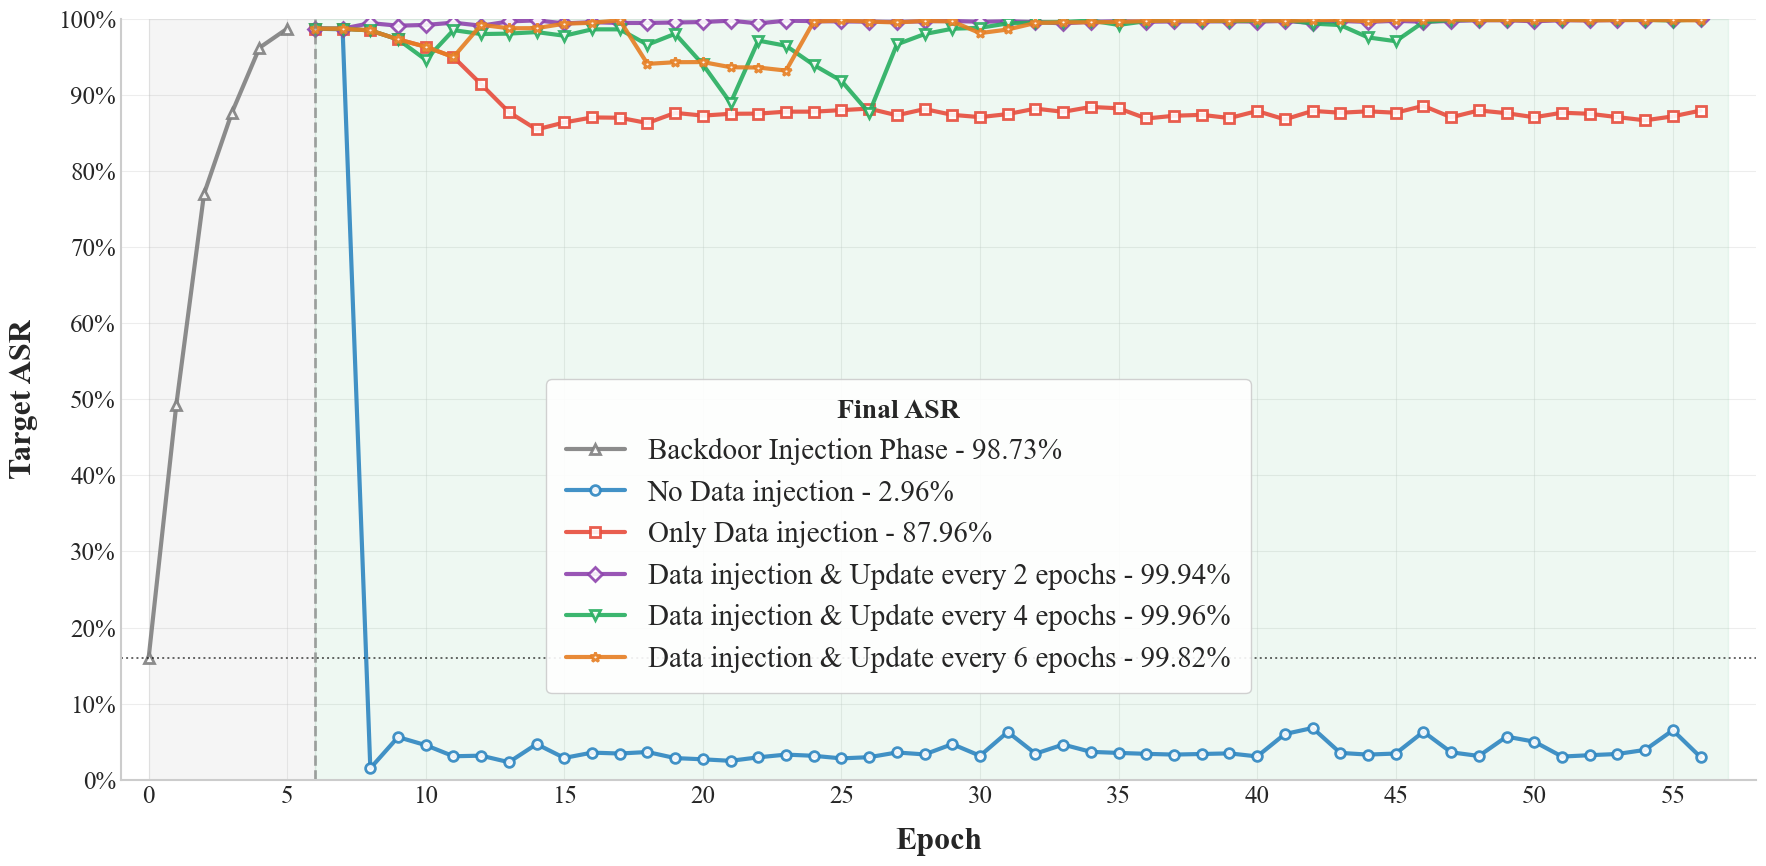

In [37]:
training_results = f"{SOURCE_DIR}/results/TSBA/iAWE/with_bd/bb_resnet_exp_3-t_2-clf_fcn/attack_metrics_resnet_to_fcn.csv"
continuous_bd_root = f"{SOURCE_DIR}/results/TSBA/iAWE/continuous_bd"
zero_injection_results = f"{continuous_bd_root}/cb_exp4_t2_surro_resnet_target_fcn/continuous_attack_metrics_fcn.csv"
only_injection_results = f"{continuous_bd_root}/cb_exp5_t2_surro_resnet_target_fcn/continuous_attack_metrics_fcn.csv"
two_epoch_gen_results = f"{continuous_bd_root}/cb_exp1_t2_surro_resnet_target_fcn/continuous_attack_metrics_fcn.csv"
four_epoch_gen_results = f"{continuous_bd_root}/cb_exp2_t2_surro_resnet_target_fcn/continuous_attack_metrics_fcn.csv"
six_epoch_gen_results = f"{continuous_bd_root}/cb_exp3_t2_surro_resnet_target_fcn/continuous_attack_metrics_fcn.csv"
print("Training Results Path:", training_results)
print("Zero Injection Results:", zero_injection_results)
print("Only Injection Results:", only_injection_results)
print("Two Epoch Gen Results:", two_epoch_gen_results)
print("Four Epoch Gen Results:", four_epoch_gen_results)
print("Six Epoch Gen Results:", six_epoch_gen_results)

training_result_df = pd.read_csv(training_results)
training_result_df = training_result_df[training_result_df["Attack Epoch"] == 2]
zero_inject_pd = pd.read_csv(zero_injection_results)
one_inject_pd = pd.read_csv(only_injection_results)
one_epoch_gen_pd = pd.read_csv(two_epoch_gen_results)
four_epoch_gen_pd = pd.read_csv(four_epoch_gen_results)
six_epoch_gen_pd = pd.read_csv(six_epoch_gen_results)

print(len(training_result_df), len(zero_inject_pd), len(one_inject_pd), len(one_epoch_gen_pd), len(four_epoch_gen_pd), len(six_epoch_gen_pd))

# Data (already prepared earlier)
training_asr = training_result_df['Target ASR'].values
zero_inject_asr = zero_inject_pd['Target ASR'].values
one_inject_asr = one_inject_pd['Target ASR'].values
one_epoch_gen_asr = one_epoch_gen_pd['Target ASR'].values
four_epoch_gen_asr = four_epoch_gen_pd['Target ASR'].values
six_epoch_gen_asr = six_epoch_gen_pd['Target ASR'].values
training_asr[-1] = zero_inject_asr[0]

draw_backdoor_analysis(training_asr, 
                       zero_inject_asr, 
                       one_inject_asr, 
                       one_epoch_gen_asr, 
                       four_epoch_gen_asr, 
                       six_epoch_gen_asr, 
                       legend_axis=(0.7, 0.32))